In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import mapclassify
from sklearn.neighbors import KDTree
import folium

plt.rcParams['figure.figsize'] = 10, 8
%matplotlib inline

OSError: Could not find libspatialindex_c library file

### Знакомство с shapely

`Shapely` - библиотека для работы с геометрическими объектами

`Geopandas` - pandas, только с гео

`folium` - для визуализации

In [2]:
from shapely.geometry import Point, LineString, Polygon

#### точка

In [3]:
moscow_lon = 37.618423
moscow_lat = 55.751244
point = Point(moscow_lon, moscow_lat)

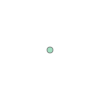

In [4]:
point

In [5]:
print("area ", point.area)
print("length ", point.length)

area  0.0
length  0.0


In [6]:
point.bounds

(37.618423, 55.751244, 37.618423, 55.751244)

#### Линия

In [7]:
moscow_lon = 37.618423
moscow_lat = 55.751244

piter_lon = 30.26417
piter_lat = 59.89444

line = LineString([(moscow_lon, moscow_lat), (piter_lon, piter_lat)])

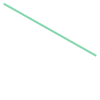

In [8]:
line

bounds - (minx, miny, maxx, maxy) 

In [9]:
line.bounds

(30.26417, 55.751244, 37.618423, 59.89444)

In [10]:
list(line.coords)

[(37.618423, 55.751244), (30.26417, 59.89444)]

#### Полигон

https://boundingbox.klokantech.com/ - сайт для создания bounding box города

In [11]:
polygon = Polygon([(37.3193289,55.489927), 
                   (37.9456611,55.489927),
                   (37.9456611,56.009657),
                   (37.3193289,56.009657)])
print(polygon.area)
print(polygon.length)

0.32552363430599734
2.2921243999999916


In [12]:
polygon.wkt

'POLYGON ((37.3193289 55.489927, 37.9456611 55.489927, 37.9456611 56.009657, 37.3193289 56.009657, 37.3193289 55.489927))'

Границы полигона

In [13]:
polygon.bounds

(37.3193289, 55.489927, 37.9456611, 56.009657)

Для полигона, у которого внутри дырка, можно найти внутренние и внешние границы

In [14]:
list(polygon.exterior.coords)

[(37.3193289, 55.489927),
 (37.9456611, 55.489927),
 (37.9456611, 56.009657),
 (37.3193289, 56.009657),
 (37.3193289, 55.489927)]

In [15]:
list(polygon.interiors)

[]

In [16]:
polygon2 = gpd.read_file('polygon_with_hole.shp')

In [17]:
polygon2.exterior

0    LINEARRING (37.18664423132671 58.1041328804995...
dtype: object

In [18]:
polygon2.interiors

0    [LINEARRING (37.17739113595358 58.051291237830...
dtype: object

### Операции с геометрией

<img src=http://docs.qgis.org/testing/en/_images/overlay_operations.png>

intersection

In [19]:
a = Point(0, 0).buffer(1.1)
b = Point(1, 1).buffer(0.7)

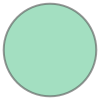

In [20]:
a

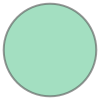

In [21]:
b

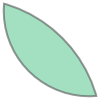

In [22]:
a.intersection(b)

union

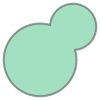

In [23]:
a.union(b)

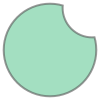

In [24]:
a.difference(b)

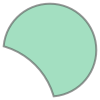

In [25]:
b.difference(a)

contains

In [26]:
polygon.contains(Point(moscow_lon, moscow_lat))

True

In [27]:
polygon.contains(Point(piter_lon, piter_lat))

False

### Geopandas

In [28]:
geo_series = gpd.GeoSeries([Point(-120, 45), Point(-121.2, 46), Point(-122.9, 47.5)])
geo_series

0        POINT (-120 45)
1      POINT (-121.2 46)
2    POINT (-122.9 47.5)
dtype: object

In [29]:
geo_series.crs = {'init': 'epsg:4326'}

#### GeoDataFrame

In [30]:
moscow_districts = gpd.read_file('moscow_districts.geojson')

In [31]:
moscow_districts.columns = moscow_districts.columns.str.lower()

In [32]:
moscow_districts.head()

abbrev_ao  men18_27  men18_60  menolder60            name  retirement  \
0       ЗАО    2550.0   15063.0      6621.0  Филёвский Парк     24272.0   
1     ЗелАО    2277.0   11418.0      4116.0       Матушкино     15058.0   
2       ЗАО    1054.0    5767.0      1614.0         Внуково      6399.0   
3     ЗелАО    1628.0    8830.0      3540.0         Савёлки     12807.0   
4     ЗелАО    1822.0   11186.0      4712.0          Силино     15518.0   

   totalmen  totalpopul  totalwomen  under18  women18_55  womenolder  \
0   26066.0     62378.0     36312.0   8474.0     14569.0     17651.0   
1   19196.0     44258.0     25062.0   6834.0     10948.0     10942.0   
2    9174.0     21378.0     12204.0   3436.0      5775.0      4785.0   
3   15214.0     35510.0     20296.0   5494.0      8379.0      9267.0   
4   19343.0     43495.0     24152.0   6587.0     10204.0     10806.0   

   working_ag                                           geometry  
0     29632.0  POLYGON ((37.4276499 55.7482092, 37.4284863 55...  
1     22366.0  POLYGON ((37.1785294 56.0079518, 37.1808275 56...  
2     11542.0  (POLYGON ((37.1831699 55.6056473, 37.184554 55...  
3     17209.0  POLYGON ((37.2094634 56.0008286, 37.2097536 56...  
4     21390.0  POLYGON ((37.1316021 56.0164459, 37.1326592 56...

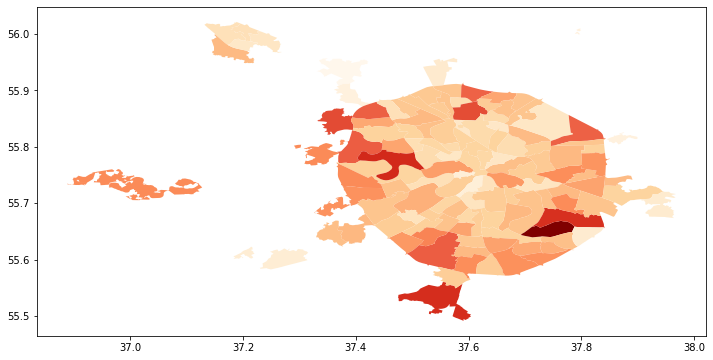

In [33]:
moscow_districts.plot('totalpopul', 
                      figsize=(12,10), 
                      cmap='OrRd');

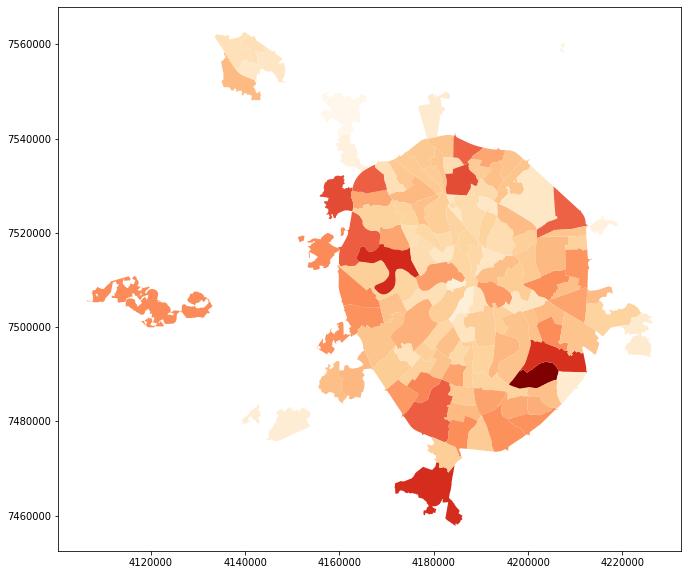

In [34]:
moscow_districts.to_crs(epsg=3857).plot('totalpopul', 
                                        figsize=(12,10), 
                                        cmap='OrRd')

#### OpenStreetMap

Скачаем данные по местам из OpenStreetMap на примере Москвы

https://wiki.openstreetmap.org/wiki/Main_Page

`node` - точка, параметры широта и долгота

`way` - линейные объекты, например улица, дорога

`relation` - отношение, для связи между объектами

In [35]:
import requests

https://wiki.openstreetmap.org/wiki/Map_Features - информация по категориям

In [36]:
%%time
overpass_url = "https://overpass.kumi.systems/api/interpreter"

overpass_query = """
[out:json];
(
 node["shop"](55.4245,37.0919,56.0671,38.1335);
);
out body;
"""
response = requests.get(overpass_url, 
                        params={'data': overpass_query})
data = response.json()

CPU times: user 327 ms, sys: 72.2 ms, total: 399 ms
Wall time: 18.4 s


In [37]:
data

{'version': 0.6,
 'generator': 'Overpass API 0.7.55.7 8b86ff77',
 'osm3s': {'timestamp_osm_base': '2019-05-29T12:11:02Z',
  'copyright': 'The data included in this document is from www.openstreetmap.org. The data is made available under ODbL.'},
 'elements': [{'type': 'node',
   'id': 1000,
   'lat': 55.9951147,
   'lon': 37.2075319,
   'tags': {'comment': 'ООО "АСП-ГРУПП", ИНН 7735108290, до 22:45 c 2014-05-23',
    'name': 'Десяточка',
    'opening_hours': '08:30-22:45',
    'shop': 'supermarket'}},
  {'type': 'node',
   'id': 82788641,
   'lat': 55.5683151,
   'lon': 37.592322,
   'tags': {'amenity': 'fuel',
    'fuel:diesel': 'yes',
    'fuel:octane_92': 'yes',
    'fuel:octane_95': 'yes',
    'fuel:octane_98': 'yes',
    'name': 'BP Бутово',
    'operator': 'BP',
    'shop': 'yes'}},
  {'type': 'node',
   'id': 245868628,
   'lat': 55.9137905,
   'lon': 37.3973647,
   'tags': {'addr:city': 'Химки',
    'addr:housenumber': 'к4',
    'addr:postcode': '141400',
    'addr:street': 'ми

In [38]:
def get_tag(x, key_name):
    if str(key_name) in x:
        tmp = x[key_name]
        return tmp
    else:
        return "unknown"

In [39]:
loaded = pd.DataFrame(data['elements'])
loaded['shop'] = loaded['tags'].apply(lambda x: get_tag(x, 'shop'))
loaded['shop_name'] = loaded['tags'].apply(lambda x: get_tag(x, 'name'))

In [40]:
loaded.head()

id        lat        lon  \
0       1000  55.995115  37.207532   
1   82788641  55.568315  37.592322   
2  245868628  55.913790  37.397365   
3  245868630  55.910621  37.399770   
4  245869056  55.911984  37.392815   

                                                tags  type          shop  \
0  {'comment': 'ООО "АСП-ГРУПП", ИНН 7735108290, ...  node   supermarket   
1  {'amenity': 'fuel', 'fuel:diesel': 'yes', 'fue...  node           yes   
2  {'addr:city': 'Химки', 'addr:housenumber': 'к4...  node   supermarket   
3  {'addr:city': 'Химки', 'addr:housenumber': 'с1...  node     furniture   
4  {'addr:city': 'Химки', 'addr:housenumber': 'к3...  node  doityourself   

   shop_name  
0  Десяточка  
1  BP Бутово  
2       Ашан  
3       ИКЕА  
4  ОБИ Химки

#### Создание geodataframe

In [41]:
crs = {'init' :'epsg:4326'}
geometry = [Point(xy) for xy in zip(loaded.lon, loaded.lat)]
places_geo = gpd.GeoDataFrame(loaded, crs=crs, geometry=geometry)
places_geo.head()

id        lat        lon  \
0       1000  55.995115  37.207532   
1   82788641  55.568315  37.592322   
2  245868628  55.913790  37.397365   
3  245868630  55.910621  37.399770   
4  245869056  55.911984  37.392815   

                                                tags  type          shop  \
0  {'comment': 'ООО "АСП-ГРУПП", ИНН 7735108290, ...  node   supermarket   
1  {'amenity': 'fuel', 'fuel:diesel': 'yes', 'fue...  node           yes   
2  {'addr:city': 'Химки', 'addr:housenumber': 'к4...  node   supermarket   
3  {'addr:city': 'Химки', 'addr:housenumber': 'с1...  node     furniture   
4  {'addr:city': 'Химки', 'addr:housenumber': 'к3...  node  doityourself   

   shop_name                       geometry  
0  Десяточка  POINT (37.2075319 55.9951147)  
1  BP Бутово   POINT (37.592322 55.5683151)  
2       Ашан  POINT (37.3973647 55.9137905)  
3       ИКЕА  POINT (37.3997698 55.9106209)  
4  ОБИ Химки   POINT (37.392815 55.9119844)

### Spatial join

проверка проекций - у двух датафреймов они должны совпадать

In [42]:
moscow_districts.crs == places_geo.crs

True

In [43]:
print(moscow_districts.crs, places_geo.crs)

{'init': 'epsg:4326'} {'init': 'epsg:4326'}


In [44]:
places_district = gpd.sjoin(moscow_districts, places_geo, how="inner", op='contains')

In [45]:
places_district.head()

abbrev_ao  men18_27  men18_60  menolder60            name  retirement  \
0       ЗАО    2550.0   15063.0      6621.0  Филёвский Парк     24272.0   
0       ЗАО    2550.0   15063.0      6621.0  Филёвский Парк     24272.0   
0       ЗАО    2550.0   15063.0      6621.0  Филёвский Парк     24272.0   
0       ЗАО    2550.0   15063.0      6621.0  Филёвский Парк     24272.0   
0       ЗАО    2550.0   15063.0      6621.0  Филёвский Парк     24272.0   

   totalmen  totalpopul  totalwomen  under18  ...  working_ag  \
0   26066.0     62378.0     36312.0   8474.0  ...     29632.0   
0   26066.0     62378.0     36312.0   8474.0  ...     29632.0   
0   26066.0     62378.0     36312.0   8474.0  ...     29632.0   
0   26066.0     62378.0     36312.0   8474.0  ...     29632.0   
0   26066.0     62378.0     36312.0   8474.0  ...     29632.0   

                                            geometry  index_right          id  \
0  POLYGON ((37.4276499 55.7482092, 37.4284863 55...         9694  2616155262   
0  POLYGON ((37.4276499 55.7482092, 37.4284863 55...        33547  5536234622   
0  POLYGON ((37.4276499 55.7482092, 37.4284863 55...         7297  2115775646   
0  POLYGON ((37.4276499 55.7482092, 37.4284863 55...         2948  1207691375   
0  POLYGON ((37.4276499 55.7482092, 37.4284863 55...         9695  2616155265   

         lat        lon                                               tags  \
0  55.744540  37.497639  {'brand': 'МТС', 'contact:facebook': 'https://...   
0  55.744553  37.509124  {'email': '9267096677@mail.ru', 'name': 'Паша ...   
0  55.744559  37.498186  {'brand': 'Магнолия', 'contact:email': 'magnol...   
0  55.744574  37.497579                                {'shop': 'alcohol'}   
0  55.744618  37.497577  {'name': 'Рублевский', 'phone': '+74957717114'...   

   type           shop     shop_name  
0  node   mobile_phone           МТС  
0  node  confectionery  Паша Пахлава  
0  node    supermarket      Магнолия  
0  node        alcohol       unknown  
0  node        butcher    Рублевский  

[5 rows x 22 columns]

In [46]:
places_district['shop_count'] = places_district.groupby('name')['id'].transform('nunique')

In [47]:
district_stats = places_district[['name','geometry', 'shop_count', 'totalpopul']].drop_duplicates('name')#

In [48]:
map_scheme = ['box_plot', 'equal_interval', 
          'fisher_jenks', 'fisher_jenks_sampled', 
          'headtail_breaks', 'jenks_caspall', 
          'jenks_caspall_forced', 'jenks_caspall_sampled', 
          'max_p_classifier', 'maximum_breaks', 'natural_breaks', 
          'quantiles', 'percentiles', 'std_mean', 'user_defined']

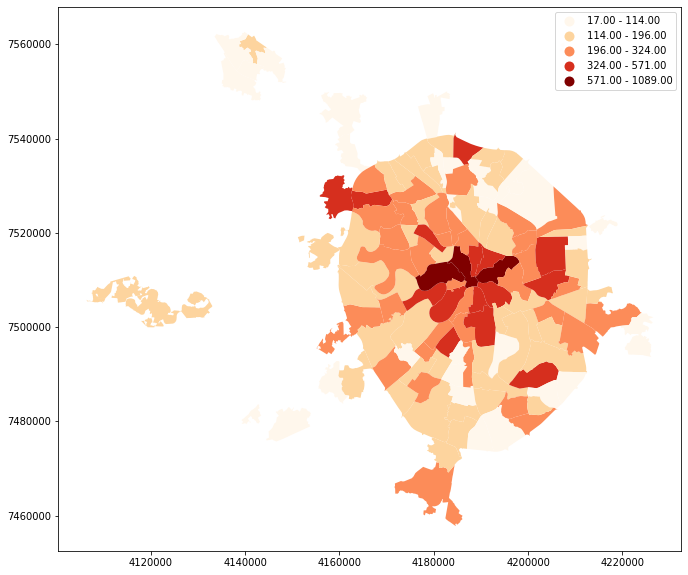

In [49]:
district_stats.to_crs(epsg=3857).plot('shop_count', 
                                      cmap='OrRd', 
                                      scheme='natural_breaks',
                                      figsize=(12,10),
                                      legend=True);

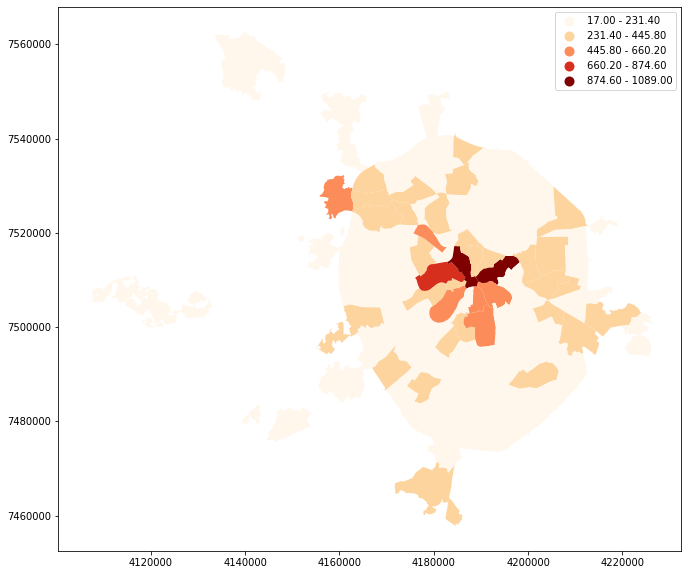

In [50]:
district_stats.to_crs(epsg=3857).plot('shop_count', 
                                      cmap='OrRd', 
                                      scheme='equal_interval',
                                      figsize=(12,10), 
                                      legend=True);

In [51]:
district_stats.to_file('shop_per_districts.geojson', driver='GeoJSON')

In [52]:
district_stats.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 125 entries, 0 to 124
Data columns (total 4 columns):
name          125 non-null object
geometry      125 non-null object
shop_count    125 non-null int64
totalpopul    125 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.9+ KB


In [53]:
district_stats_pd = district_stats.drop(labels='geometry', axis=1)

In [54]:
bins = [0, 110, 200, 325, 600, 1100]

In [55]:
m = folium.Map(location=[55.759151, 37.618398], 
               zoom_start=10,
               tiles = "CartoDB positron")
               
folium.Choropleth(
    geo_data=district_stats,
    data=district_stats_pd,
    columns=['name','shop_count'],
    key_on = 'feature.properties.name',
    fill_color='BuPu',
    fill_opacity=0.7,
    line_opacity=0.5,
    bins=bins,
    legend_name='Число магазинов'
).add_to(m)

m

In [56]:
from folium import plugins
from folium.plugins import HeatMap

In [57]:
loaded['shop'].value_counts().reset_index().head()

index  shop
0  convenience  5951
1  supermarket  3637
2      clothes  2238
3  hairdresser  2203
4       beauty  2122

In [58]:
loaded['lat'] = loaded['lat'].astype(float)
loaded['lon'] = loaded['lon'].astype(float)

df_for_heatmap = loaded[['lat', 'lon']][loaded['shop'].isin(['convenience', 'supermarket'])]
df_for_heatmap = df_for_heatmap.dropna(axis=0, subset=['lat','lon'])

# List comprehension to make out list of lists
heat_data = [[row['lat'],row['lon']] for index, row in df_for_heatmap.iterrows()]

# Plot it on the map
HeatMap(heat_data,
        radius=10).add_to(m)

# Display the map
m

In [59]:
m = folium.Map(location=[55.759151, 37.618398], 
               zoom_start=10,
               tiles = "CartoDB positron")

#choropleth
shop_choropleth = folium.Choropleth(
                        geo_data=district_stats,
                        data=district_stats_pd,
                        columns=['name','shop_count'],
                        key_on = 'feature.properties.name',
                        fill_color='BuPu',
                        fill_opacity=0.7,
                        line_opacity=0.5,
                        show=False,
                        bins=bins,
                        legend_name='Число магазинов')

#heatmap
shop_heatmap = HeatMap(heat_data,
                       radius=15,
                      blur=15)


shop_choropleth.layer_name = 'Количество магазинов в районе'
shop_heatmap.layer_name = 'Плотность магазинов'

# Display the map
m.add_child(shop_choropleth)
m.add_child(shop_heatmap)

# add the layer control
folium.LayerControl().add_to(m)
m

#### OSMNX and Street Analysis

In [60]:
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
from descartes import PolygonPatch
ox.config(log_console=True, use_cache=True)
ox.__version__

'0.10'

In [61]:
lon_min = 37.589626
lon_max = 37.63306
lat_min = 55.760103
lat_max = 55.781633

trip_times = [5, 10, 15, 20, 25] #in minutes
travel_speed = 4.5 #walking speed in km/hour

Загрузка графа улиц по bbox

In [63]:
G_ = ox.graph_from_bbox(lat_max, lat_min, lon_max, lon_min,
                        timeout=240,
                        network_type='walk')
G = ox.project_graph(G_)
ox.plot_graph(G)

ConnectionError: HTTPConnectionPool(host='overpass-api.de', port=80): Max retries exceeded with url: /api/interpreter (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x131a25240>: Failed to establish a new connection: [Errno 60] Operation timed out',))

Создаем геодатафрэйм из дорожного графа

In [ ]:
gdf_nodes = ox.graph_to_gdfs(G_, edges=False)

Добавляем координаты точки

In [ ]:
target_pnt = (55.773472,37.6057714)

Определяем для точки ближайшую ноду из графа

In [ ]:
tree = KDTree(gdf_nodes[['y', 'x']], metric='euclidean')

closest_idx = tree.query([target_pnt], k=1, return_distance=False)[0]

closest_node_to_target = gdf_nodes.iloc[closest_idx].index.values[0]
closest_node_to_target

Создаем лист значений цвета для изохрон

In [64]:
# get one color for each isochrone
iso_colors = ox.get_colors(n=len(trip_times), cmap='Reds', start=0.3, return_hex=True)
iso_colors

['#FCAB8E', '#FB7252', '#E73328', '#B31218', '#67000C']

Визуализация нод в соответствии с их доступностью

In [ ]:
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, closest_node_to_target, radius=trip_time, distance='time')
    for node in subgraph.nodes():
        node_colors[node] = color
        
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [20 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(G, fig_height=8, node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=2)

Создание изохрон в виде полигонов

In [ ]:
isochrone_polys = []
for trip_time in sorted(trip_times, reverse=True):
    subgraph = nx.ego_graph(G, closest_node_to_target, 
                            radius=trip_time, distance='time')
    
    node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
    
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    
    isochrone_polys.append(bounding_poly)

Добавляем граф и изохроны в качестве полигональных объектов

In [ ]:
fig, ax = ox.plot_graph(G, fig_height=8, 
                        show=False, 
                        close=False, 
                        edge_color='k', 
                        edge_alpha=0.2, 
                        node_color='none')

for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)
    
plt.show()

Создаем более точные изохроны в соответствии с доступ

In [ ]:
def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, closest_node_to_target, 
                                radius=trip_time, distance='time')

        node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({'id': subgraph.nodes()}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index('id')

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lines.append(LineString([f,t]))

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union
        
        
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys


In [ ]:
isochrone_polys = make_iso_polys(G, edge_buff=20, node_buff=10, infill=True)

fig, ax = ox.plot_graph(G, fig_height=8, 
                        show=False, close=False, 
                        edge_color='k', edge_alpha=0.2, node_color='none')

for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)
plt.show()

#### Построение маршрутов с помощью OSMNX

Геокодинг нужных адресов

In [67]:
pointA = ox.geocode('Москва, Долгоруковская улица, 2')
pointB = ox.geocode('Москва, Тверская улица, 22')

In [68]:
pointA, pointB

((55.7747607, 37.6041419), (55.7679018, 37.6004854))

Определяем ближайшую ноду из графа

In [70]:
tree = KDTree(gdf_nodes[['y', 'x']], metric='euclidean')

A_idx = tree.query([pointA], k=1, return_distance=False)[0]
B_idx = tree.query([pointB], k=1, return_distance=False)[0]

closest_node_to_A = gdf_nodes.iloc[A_idx].index.values[0]
closest_node_to_B = gdf_nodes.iloc[B_idx].index.values[0]

NameError: name 'gdf_nodes' is not defined

Строим маршрут

In [ ]:
route = nx.shortest_path(G, closest_node_to_A, closest_node_to_B)

fig, ax = ox.plot_graph_route(G, route,
                              show=False, close=False, 
                              orig_dest_node_color='green',
                              route_color='green')

ax.scatter(pointA[1], pointA[0], c='red', s=100)
ax.scatter(pointB[1], pointB[0], c='blue', s=100)

plt.show()

Отображаем маршрут на веб-карте

In [ ]:
m = ox.plot_route_folium(G_, 
                         route, 
                         route_color='green')

folium.Marker(location=pointA, icon=folium.Icon(color='red')).add_to(m)
folium.Marker(location=pointB, icon=folium.Icon(color='blue')).add_to(m)
m

Создаем геодатафрейм из полигонов-изохрон

In [ ]:
isochrone_polys

In [ ]:
iso_plgn = gpd.GeoDataFrame(pd.DataFrame(trip_times[::-1], 
                                         columns=['times']),
                           geometry = gpd.GeoSeries(isochrone_polys))

In [ ]:
iso_plgn.crs = {'init':'epsg:32637'}
iso_plgn = iso_plgn.to_crs({'init':'epsg:4326'})
iso_plgn.head()

##### Задание: Количество магазинов в пешеходной доступности

In [ ]:
###you code here